In [1]:
import utils

2025-03-03 14:41:07.045385: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-03 14:41:07.045447: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-03 14:41:07.045471: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Setup config

In [2]:
# from configs.loca_imnet1k_base16 import get_config
from configs.loca_mmearth64_small16 import get_config

config = get_config()
config.batch_size = 2

In [3]:
config.model.hidden_size

384

## Setup Dataset

In [4]:
from scenic.train_lib import train_utils
import jax.numpy as jnp
import loca_dataset
import ops
import jax

rng = jax.random.key(77)
data_rng, rng = jax.random.split(rng)

dataset = train_utils.get_dataset(config, data_rng)

/home/admin/anaconda3/envs/flax/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2025-03-03 14:41:10.764952: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: meta

### Dataset stats

In [5]:
def remove_batch_dim0(batch, debug=False):
    # Remove dim 0. (Don't know where extra dim is added at 0)
    for k, v in batch.items():
        batch[k] = v.squeeze(0)
        if debug:
            print(f"batch[{k}]: {batch[k].shape}")

    return batch

In [6]:
batch = next(dataset.train_iter)
batch = remove_batch_dim0(batch)
batch = utils.prepare_input(batch, config)

print("mean", batch['reference'].reshape(-1, 12).mean(axis=0))
print("min", batch['reference'].reshape(-1, 12).min(axis=0))
print("max", batch['reference'].reshape(-1, 12).max(axis=0))
print("std", batch['reference'].reshape(-1, 12).std(axis=0))

E0303 14:41:18.276084  806648 hlo_lexer.cc:443] Failed to parse int literal: 23244080047654493209


mean [-0.18771927 -0.21901405 -0.2504982  -0.36068147 -0.34107044 -0.11861882
  0.02490885  0.12839252 -0.00427988 -0.41646677 -0.07444118 -0.36417264]
min [-0.49536067 -0.564733   -0.60946333 -0.7189742  -0.6417791  -0.65743124
 -0.7092204  -0.7049997  -0.753405   -0.7546706  -0.61618584 -0.82639456]
max [0.33937833 0.48739353 0.45053852 0.26630726 0.16170785 0.41325042
 0.6439889  0.71989363 0.5701848  0.07800584 0.6028796  0.3952758 ]
std [0.28316137 0.29247215 0.28342426 0.2280264  0.18324386 0.25573367
 0.35441315 0.3651004  0.31760684 0.21248412 0.21433954 0.20539658]


In [7]:
print("mean", batch['query0'].reshape(-1, 12).mean(axis=0))
print("min", batch['query0'].reshape(-1, 12).min(axis=0))
print("max", batch['query0'].reshape(-1, 12).max(axis=0))
print("std", batch['query0'].reshape(-1, 12).std(axis=0))

mean [-0.16031581 -0.20408414 -0.23159494 -0.3471239  -0.32996455 -0.10513477
  0.03620569  0.13673753  0.00061208 -0.40029362 -0.09282651 -0.35615912]
min [-0.4953645  -0.576707   -0.64433664 -0.7413887  -0.6934142  -0.6575483
 -0.7095605  -0.70557714 -0.7530149  -0.66233623 -0.5902221  -0.7884034 ]
max [0.33949006 0.48338366 0.45226195 0.26980698 0.17174782 0.41875112
 0.6434866  0.7195059  0.5695827  0.09659754 0.5180588  0.35673693]
std [0.31178433 0.3155574  0.31195572 0.2596287  0.21452892 0.2786637
 0.3719837  0.37980735 0.32818186 0.19779441 0.19121638 0.20379785]


In [8]:
print("mean", batch['queries'].reshape(-1, 12).mean(axis=0))
print("min", batch['queries'].reshape(-1, 12).min(axis=0))
print("max", batch['queries'].reshape(-1, 12).max(axis=0))
print("std", batch['queries'].reshape(-1, 12).std(axis=0))

mean [-0.17489575 -0.20208874 -0.23450734 -0.35147753 -0.33325845 -0.1079131
  0.0356751   0.1418464   0.0108359  -0.40070292 -0.07752158 -0.36546585]
min [-0.4954074  -0.57651436 -0.64575255 -0.74233395 -0.6934669  -0.657249
 -0.7096035  -0.7058098  -0.7536415  -0.78514695 -0.5927625  -0.78918755]
max [0.40704036 0.7000512  0.6526116  0.39819604 0.24532847 0.45223933
 0.64363766 0.7199686  0.7315344  0.10956694 0.6029156  0.39416617]
std [0.3005376  0.31760874 0.3086886  0.24965435 0.20190786 0.2634839
 0.3542234  0.3557754  0.31538722 0.2072458  0.18739396 0.18564631]


## Visualise data

ValueError: Incompatible shapes for broadcasting: shapes=[(224, 224, 12), (3,)]

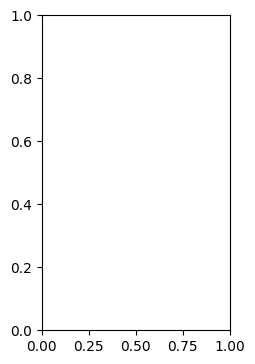

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from configs.loca_imnet1k_base16 import MEAN_RGB, STDDEV_RGB

viz_batch = next(dataset.train_iter)
viz_batch = remove_batch_dim0(viz_batch)
viz_batch = utils.prepare_input(viz_batch, config)

fig = plt.figure(figsize=(17, 9))

gs0 = gridspec.GridSpec(2, 6, figure=fig)

# Plot reference
gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[0])
ax1 = fig.add_subplot(gs00[:2, :2])
ref_img = (viz_batch['reference'][0] * jnp.array(STDDEV_RGB) + jnp.array(MEAN_RGB))
ax1.imshow(ref_img)

# Plot queries
# n_q_foc = config.dataset_configs.number_of_focal_queries
# queries = viz_batch['queries'].reshape(n_q_foc, config.batch_size, 96, 96, 3)
# gs01 = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs0[1:])
# for i, query in enumerate(queries[:4]):
#     ax = fig.add_subplot(gs01[0, i])
#     ax.imshow(query[0] * jnp.array(STDDEV_RGB) + jnp.array(MEAN_RGB))
#     ax.set_title(f'Query {i + 1} Crop')

## Load Model

In [11]:
import flax
from flax.training import checkpoints
import optax
from scenic.train_lib import lr_schedules
import vit
import copy

train_state = None

model = vit.ViTLOCAModel(config, dataset.meta_data)

rng, init_rng = jax.random.split(rng)
(params, _, num_trainable_params, gflops) = train_utils.initialize_model(
    model_def=model.flax_model,
    input_spec=[
        (dataset.meta_data['input_shape'], dataset.meta_data.get('input_dtype', jnp.float32))],
    config=config, rngs=init_rng
)

# Only one model function but two sets of parameters.
ema_params = copy.deepcopy(params)

learning_rate_fn = lr_schedules.get_learning_rate_fn(config)
momentum_parameter_scheduler = lr_schedules.compound_lr_scheduler(
  config.momentum_rate)

weight_decay_mask = jax.tree_util.tree_map(lambda x: x.ndim != 1, params)
tx = optax.inject_hyperparams(optax.adamw)(
  learning_rate=learning_rate_fn, weight_decay=config.weight_decay,
  mask=weight_decay_mask)

opt_state = jax.jit(tx.init, backend='cpu')(params)

chrono = train_utils.Chrono()

train_state = utils.TrainState(
  global_step=0, opt_state=opt_state, tx=tx, params=params,
  ema_params=ema_params, rng=rng, metadata={'chrono': chrono.save()})

checkpoint_path = "/home/admin/john/scenic/loca_mmearth_small_imnet_init_no_masking/checkpoint_10001"
train_state = checkpoints.restore_checkpoint(checkpoint_path, train_state)

## Run Inference

In [10]:
batch = next(dataset.train_iter)

batch = remove_batch_dim0(batch)
batch = utils.prepare_input(batch, config)

In [13]:
dropout_rng, droptok_rng = jax.random.split(rng)

use_ema = True
drop_moment = "late"

_, r_feat_targets, r_patch_features, _  = model.flax_model.apply(
    {'params': train_state.ema_params if use_ema else train_state.params},
    batch['reference'],
    seqlen=config.reference_seqlen,
    seqlen_selection=config.reference_seqlen_selection,
    drop_moment=drop_moment,
    train=False,
    rngs={'dropout': dropout_rng, 'droptok': droptok_rng}
)

In [14]:
use_pe = False

q_rand_loc_pred, q_rand_feat_pred, q_rand_patches, q_rand_idx_kept = model.flax_model.apply(
    {'params': train_state.params},
    batch['query0'],
    inputs_kv=r_patch_features,
    seqlen=config.query_max_seqlen,
    use_pe=use_pe,
    # drop_moment='early',
    train=False,
    rngs={'dropout': dropout_rng, 'droptok': droptok_rng})

In [15]:
n_q_foc = config.dataset_configs.number_of_focal_queries

q_foc_loc_pred, q_foc_feat_pred, _, _ = model.flax_model.apply(
    {'params': train_state.params},
    batch['queries'],
    inputs_kv=jnp.tile(r_patch_features, (n_q_foc, 1, 1)),
    use_pe=use_pe,
    train=False,
    rngs={'dropout': dropout_rng})

## Analyse model output

### Reference patch tokens

In [16]:
print(r_patch_features.shape)
r_patch_features[0, ::10, :4]

(2, 39, 384)


Array([[ 1.4019358e+00,  4.6016288e-01, -2.7516484e-04, -1.7784400e+00],
       [ 1.4658790e+00,  4.8058704e-01,  8.4825784e-02, -1.6955528e+00],
       [ 9.0068537e-01,  4.7912169e-01, -1.2597889e-02, -1.6507332e+00],
       [ 1.1265972e+00,  5.0279534e-01,  7.9267055e-02, -1.7464702e+00]],      dtype=float32)

### Query-rand patch tokens

In [17]:
print(q_rand_patches.shape)
q_rand_patches[:2, ::10, :4]

(2, 70, 384)


Array([[[ 1.268101  ,  0.48091346,  0.13477798, -1.7715516 ],
        [ 1.4263119 ,  0.51452106,  0.17681915, -1.7264183 ],
        [ 1.3345728 ,  0.52118254,  0.1939798 , -1.7853239 ],
        [ 1.2934095 ,  0.48794413,  0.13346367, -1.7956016 ],
        [ 1.2291298 ,  0.5058667 ,  0.19670935, -1.8104303 ],
        [ 1.3415799 ,  0.50265896,  0.19885959, -1.7227664 ],
        [ 1.4075786 ,  0.44967932,  0.13341206, -1.7287409 ]],

       [[ 0.9282264 ,  0.4194695 ,  0.20120344, -1.7947829 ],
        [ 0.9995402 ,  0.44482228,  0.20411116, -1.8283885 ],
        [ 0.97461027,  0.47224328,  0.2867266 , -1.8094745 ],
        [ 0.99538326,  0.4742521 ,  0.2654637 , -1.8225155 ],
        [ 1.0120455 ,  0.47611347,  0.25955772, -1.8114011 ],
        [ 1.0797647 ,  0.44620654,  0.21053493, -1.8348403 ],
        [ 1.031066  ,  0.41273952,  0.22924952, -1.772064  ]]],      dtype=float32)

### `Q_rand` location targets

In [18]:
q_rand_targets = batch["query0_target_position"]
print(q_rand_targets[0].squeeze(-1))

[[ -1  -1  -1  -1  42  43  44  45  46  47  47  49  49  50]
 [ -1  -1  -1  -1  42  43  44  45  46  47  47  49  49  50]
 [ -1  -1  -1  -1  56  57  58  59  60  61  61  63  63  64]
 [ -1  -1  -1  -1  70  71  72  73  74  75  75  77  77  78]
 [ -1  -1  -1  -1  84  85  86  87  88  89  89  91  91  92]
 [ -1  -1  -1  -1  98  99 100 101 102 103 103 105 105 106]
 [ -1  -1  -1  -1 112 113 114 115 116 117 117 119 119 120]
 [ -1  -1  -1  -1 126 127 128 129 130 131 131 133 133 134]
 [ -1  -1  -1  -1 140 141 142 143 144 145 145 147 147 148]
 [ -1  -1  -1  -1 154 155 156 157 158 159 159 161 161 162]
 [ -1  -1  -1  -1 168 169 170 171 172 173 173 175 175 176]
 [ -1  -1  -1  -1 182 183 184 185 186 187 187 189 189 190]
 [ -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1]
 [ -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1]]


In [19]:
print("batch['query0_target_position']", batch['query0_target_position'].shape)
q_rand_loc_targets = batch['query0_target_position'].reshape(config.batch_size, -1)
q_rand_loc_targets = jnp.take(q_rand_loc_targets, q_rand_idx_kept, axis=1)
q_rand_intersect = q_rand_loc_targets != -1
print(q_rand_loc_targets[0][q_rand_intersect[0]].mean())
q_rand_loc_targets[0][q_rand_intersect[0]]

batch['query0_target_position'] (2, 14, 14, 1)
108.35715


Array([ 77, 120, 176,  91,  91,  44,  60, 134, 143, 103, 131, 186, 189,
       175, 157,  46, 113, 159,  45, 130, 117, 128, 161,  77,  49, 158,
        61,  50, 175, 114, 173,  63,  56,  47,  63, 133,  46,  86,  47,
       105, 184,  88], dtype=int32)

### `q_rand` location predictions

In [20]:
import flax.linen as nn

print("q_rand_loc_pred", q_rand_loc_pred.shape)

q_rand_loc_pred[0][q_rand_intersect[0]].argmax(axis=1)

q_rand_loc_pred (2, 70, 196)


Array([ 86, 169, 183, 168, 168,  58, 154, 169, 169, 168,   6, 182, 182,
       182, 169,  59, 168, 168,  59, 168, 168, 168, 183, 100, 168, 169,
       168,  85, 183, 168, 168, 168,  71,  59, 168,  85,  59,  86,  59,
       168, 169, 100], dtype=int32)

### Query location targets

In [21]:
q_foc_targets = batch["target_positions"]
print(q_foc_targets.shape)

q_foc_targets[0]

(18, 36)


Array([-1, -1, -1, -1, -1, -1,  5,  3,  1, -1, -1, -1, 19, 17, 15, -1, -1,
       -1, 47, 45, 43, -1, -1, -1, 61, 59, 57, -1, -1, -1, 89, 87, 85, -1,
       -1, -1], dtype=int32)

### Query location prediction

In [22]:
print(q_foc_loc_pred.shape)
q_foc_loc_pred[0].argmax(axis=1)

(18, 36, 196)


Array([17,  7,  6,  6, 20,  5, 17, 17, 17,  6,  6,  6, 31, 31, 17,  4,  6,
        6, 45, 45, 31, 17,  6,  6, 60, 46, 44, 43, 42,  6, 74, 72, 71, 71,
       57, 44], dtype=int32)

### Visualize

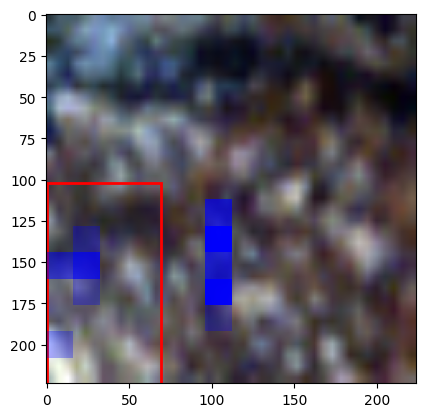

Accuracy 0.027777778
Predictions [118 118 118 118 104 146 132 118 118 118 118 146 127 127 126 113 118 118
 146 126 127 127 132 118 160 146 141 146 146 146 168 146 132 146 104 104]
Targets     [ -1  -1  98  99 100 101  -1  -1 112 113 114 115  -1  -1 126 127 128 129
  -1  -1 154 155 156 157  -1  -1 168 169 170 171  -1  -1  -1  -1  -1  -1]


In [38]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from configs.loca_mmearth64_small16 import SENTINEL2_L1C_MEAN, SENTINEL2_L1C_STD, SENTINEL2_L2A_MEAN, SENTINEL2_L2A_STD
import visualisation_utils as viz_utils


fig, (ax1) = plt.subplots(1, 1)

batch = next(dataset.train_iter)
prepped_batch = remove_batch_dim0(batch)
prepped_batch = utils.prepare_input(prepped_batch, config)

ref_img = prepped_batch['reference'][0]
is_l2a = batch['is_l2a'][0]

ref_img_rgb = viz_utils.sen2_to_rgb(ref_img, is_l2a)
ax1.imshow(ref_img_rgb)

# Visualise query bbox
# Get query bbox coordinates from batch
query_bbox = batch['query1_box'][0] * 224  # Multiplied by img size
_, y, x, h, w = query_bbox

# Create rectangle patch
rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the plot
ax1.add_patch(rect)

###
inds = jnp.arange(14 * 14).reshape(14, 14)

loc_pred = viz_utils.predict_positions(model, train_state, prepped_batch['reference'][0], batch['query1'][0])
loc_targets = batch['query1_mask'][0].reshape(-1)

for pred in loc_pred:
    row, col = jnp.where(inds == pred)
    if row.size < 1:
        continue
    row, col = row.item(), col.item()

    cell_width, cell_height = 224 // 14, 224 // 14

    rect = patches.Rectangle((col * cell_width, row * cell_height), 
                               cell_width, cell_height,
                               facecolor="blue", 
                               alpha=0.3)
    ax1.add_patch(rect)
###

plt.show()

print('Accuracy', jnp.sum(loc_pred == loc_targets) / loc_targets.size)
print('Predictions', loc_pred)
print('Targets    ', loc_targets)

In [149]:
loc_pred = predict_positions(train_state, prepped_batch['reference'][0], batch['query1'][0])
loc_pred.shape

(36,)

In [163]:
loc_pred

Array([131, 131, 159, 160, 160, 146, 131, 131, 146, 146, 146, 132, 131,
       146, 146, 146, 146, 132, 131, 146, 146, 146, 146, 132, 131, 146,
       145, 146, 146, 146, 131, 132, 146, 146, 146, 146], dtype=int32)

In [87]:
batch.keys()

dict_keys(['is_l2a', 'query0', 'query0_box', 'query0_mask', 'query1', 'query1_box', 'query1_mask', 'query2', 'query2_box', 'query2_mask', 'query3', 'query3_box', 'query3_mask', 'query4', 'query4_box', 'query4_mask', 'query5', 'query5_box', 'query5_mask', 'query6', 'query6_box', 'query6_mask', 'query7', 'query7_box', 'query7_mask', 'query8', 'query8_box', 'query8_mask', 'query9', 'query9_box', 'query9_mask', 'reference'])

In [152]:
batch['query1_mask'].reshape(-1)

Array([187, 186, 186, 185, 184, 184, 187, 186, 186, 185, 184, 184,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  86,  87,  89,
        91,  92,  94, 100, 101, 103, 105, 106, 108, 114, 115, 117, 119,
       120, 122, 128, 129, 131, 133, 134, 136, 142, 143, 145, 147, 148,
       150, 156, 157, 159, 161, 162, 164], dtype=int32)

In [130]:
inds = jnp.arange(6 * 6).reshape(6, 6)
row, col = jnp.where(inds == 36)

if row.size == 0:
    print('index not in array')

index not in array


Array([1.8600973, 1.7640591, 1.5175668, ..., 2.2889047, 2.1923099,
       1.8264052], dtype=float32)

In [112]:
q1_foc_loc_pred[0].shape

(36, 196)

In [118]:
q1_foc_loc_pred[0].argmax(axis=1)

Array([172, 171, 171, 185, 185,   7, 172, 171, 171, 185, 185,   7, 186,
       186, 185, 185, 177, 163, 186, 186, 185, 171,   7, 163, 185, 185,
       185, 185, 171, 105,   6,   7,   7,   7, 104, 105], dtype=int32)

In [119]:
batch['query1_mask'][0].reshape(-1)

Array([ -1,  -1,  41,  40,  39,  38,  -1,  -1,  55,  54,  53,  52,  -1,
        -1,  69,  68,  67,  66,  -1,  -1,  83,  82,  81,  80,  -1,  -1,
        97,  96,  95,  94,  -1,  -1, 111, 110, 109, 108], dtype=int32)